# MNISTで文字判定プログラムを作ってCNNの基本を知る
## 概要

*   手書きの0~9の数字を判定するプログラムを実装して、画像分類するCNNモデルの概略をつかむ
*   データセットはmnistを使う
*   CNNモデルはkerasで作成する






## 実装
学習して数字を判定するまでの大まかな流れ


1.   学習に使うデータの準備
2.   学習
3.   推論(学習で得られたモデルで判定する)

## step1 学習に使うデータの準備
mnistからデータセットをダウンロードする


*   keras.load_dataでmnistのデータセットをダウンロードする
*   ダウンロードしたデータセットは トレーニング用とバリデーション用に分かれている
*   データセットは 画像データ(x)と 正解ラベル(y)を持つ。正解ラベルは画像が示す数字である。

In [3]:
import keras
from keras.datasets import mnist

# mnist からトレーニングデータセットとバリデーションデータセットをダウンロードする
# xは画像データ、yは画像の判定ラベル
# x_trainデータは28*28ピクセル画像が60000枚 (60000, 28, 28)
# x_testデータは28*28ピクセル画像が10000枚 (10000, 28, 28)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### load_dataの中身

In [7]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170,
        253, 253, 253, 253, 253, 225, 172, 253, 242, 195,  64,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  49, 238, 253, 253, 253, 253,
        253, 253, 253, 253, 251,  93,  82,  82,  56,  39,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  18, 219, 253, 253, 253, 253,
        253, 198, 182, 247, 241,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  80, 156, 107, 253, 253,
        205,  11,   0,  43, 154,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   1, 154, 253,
         90,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 139, 253,
        190,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 190,
        253,  70,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35,
        241, 225, 160, 108,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         81, 240, 253, 253, 119,  25,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  45, 186, 253, 253, 150,  27,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  16,  93, 252, 253, 187,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 249, 253, 249,  64,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  46, 130, 183, 253, 253, 207,   2,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  39,
        148, 229, 253, 253, 253, 250, 182,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  24, 114, 221,
        253, 253, 253, 253, 201,  78,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  23,  66, 213, 253, 253,
        253, 253, 198,  81,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  18, 171, 219, 253, 253, 253, 253,
        195,  80,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  55, 172, 226, 253, 253, 253, 253, 244, 133,
         11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 136, 253, 25

この画像の正解ラベル y_train[0] は 5

### データの前処理
正解ラベル(y)を 10個の確率データ の形式に変換する。今の正解ラベルは 1〜9のラベルになっており、学習モデルの出力形式である10個の確率データに合わないため。
例: [0, 1, ..., 0]。左から数字1,2, ... 9の確率
画像データ(x)は扱いやすいように 0~1の間の数値にする。今は min:0(白) 〜 max:255(黒)を表す。

In [9]:
from keras.utils import to_categorical

# mnistの画像データはグレースケール画像であり、min:0(白)~max:255(黒)を表す。入力を0~1の範囲にした方が都合がよいので255で割る。
X_train = x_train.reshape(60000, 28,28,1)/255
X_test = x_test.reshape(10000, 28,28,1)/255
# 学習モデルの出力が 10個の確率データ(例: [0, 1, ..., 0])になるので、今の形式(画像が0~9のうちのどの数字か)はかみ合わない。そこで形式をそろえるために変換する
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

## step2 学習
### 学習モデルを用意する

kerasのSequentialモデルを使って学習モデルを作成する
*   Sequentialモデルはニューラルネットワークを構築するための1つの方法
*   ニューラルネットワークは複数の層（レイヤー）で構成される。Sequentialでは層を1つずつ積み重ねて構築していく。


In [10]:
from keras.models import Sequential
from keras.layers import Dense , Activation, Convolution2D , MaxPooling2D, Flatten

model = Sequential()
model.add(Convolution2D(10, (5,5), input_shape=(28,28,1), activation="relu")) # 2D畳み込み層
model.add(MaxPooling2D(2,2)) # Maxプーリング層
model.add(Convolution2D(10, (5,5), padding="same"))
model.add(MaxPooling2D(2,2))
model.add(Convolution2D(10, (5,5), padding="same"))
model.add(MaxPooling2D(2,2))
model.add(Flatten()) # 平坦化層。入力画像を１次元配列に変換して出力する。全結合層に接続する前に使われる。
model.add(Dense(10, activation="softmax")) # 全結合層

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 畳み込み層(Convolution)とは
*   画像の特徴点を見つけること
*   画像にカーネルを充てることで特徴点(特徴マップ)を得る
*   カーネルの数字によって抽出できる特徴が変わる。
*   CNNにおいてカーネルが重みであり、よいCNNモデルとは最適なカーネルを持ったモデルのことを言う。



### プーリング層(Pooling)とは
*   識別に不必要な特徴量をそぎ落とす
*   識別に必要な特徴量を抽出する処理

### 全結合層(Dense)とは


*   畳み込み層も、プーリング層も、出力は画像のまま(特徴マップ)である。
*   最終的には画像を与えると、1~9のように識別したいので、出力を１次元にしたい。そのために全結合層がある。
*   全結合層の前にFlatten層で平坦化する

In [12]:
from keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

# 学習
model.fit(X_train, Y_train, epochs=1, batch_size=100, validation_data=(X_test, Y_test), callbacks=[EarlyStopping()])

# モデル評価
score = model.evaluate(X_test, Y_test, verbose=0)
print("loss:", score[0])
print("accuracy:", score[1])

600/600 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.7577 - loss: 0.7847 - val_accuracy: 0.9615 - val_loss: 0.1323
loss: 0.13229016959667206
accuracy: 0.9614999890327454


## step3 推論してみる

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
判定結果= 7


<function matplotlib.pyplot.show(close=None, block=None)>

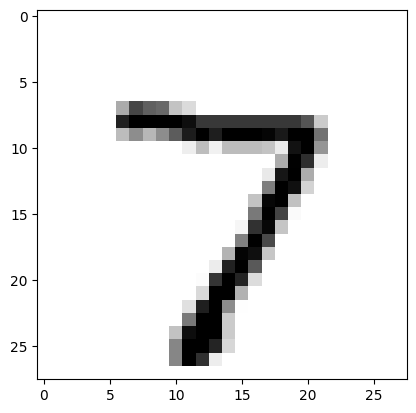

In [16]:
from keras.models import load_model
import numpy as np
from matplotlib import pyplot as plt

# 学習済みモデルを保存しておく
model.save('MNIST_NN.h5')
MNIST_NN = load_model('MNIST_NN.h5')

# 学習済みモデルに、mnistのバリデーション画像を渡して推論してみる
predicted = MNIST_NN.predict(x_test[0].reshape(1, 28, 28, 1))
print("判定結果=", np.argmax(predicted)) # 最も確率の高い数字を出力する
plt.imshow(x_test[0], cmap=plt.cm.gray_r)
plt.show

# 付録: 数字を書いて予測させてみよう
紙に書いた数字をカメラから読ませて、数字を当てさせる

In [20]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from IPython.display import Image
import cv2
import numpy as np
from PIL import Image as PILImage
import io

# カメラで写真を撮るためのJavaScript
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📷 撮影';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // 解像度
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();

        return canvas.toDataURL('image/jpeg', quality);
      }
      takePhoto({quality: %f});
    ''' % quality)
    display(js)
    data = eval_js("takePhoto()")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


In [29]:
from base64 import b64decode
from tensorflow.keras.models import load_model

# 画像を撮影
photo_path = take_photo()

# モデルを読み込み（学習済みMNIST CNNモデル）
model = load_model("MNIST_NN.h5")

# 画像を読み込んで前処理
img = PILImage.open(photo_path).convert('L')  # グレースケール
img = img.resize((28, 28))  # リサイズ
img_array = np.array(img)
img_array = 255 - img_array  # 白黒反転
img_array = img_array.astype('float32') / 255.0
img_array = img_array.reshape(1, 28, 28, 1)

# 推論
pred = model.predict(img_array)
predicted_digit = np.argmax(pred)

# 結果表示
print("📌 予測された数字:", predicted_digit)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
📌 予測された数字: 8


参考Webページ
https://qiita.com/mttt/items/781e8bcc3c22d872c2e2